In [12]:
# lets make NB distributions of expression

# testing ideas
from scipy.stats import nbinom
import matplotlib.pyplot as plt
import numpy as np
import random

import anndata as ad
import pandas as pd
from scipy.sparse import coo_matrix, csc_matrix

In [13]:
# how many samples to generate
patients_to_generate = 200
genes_to_generate = 200

theta_value = 0.1

# probability of samples/genes to be sorted
sample_sort_prob = 0.05
gene_sort_prob = 0.05

# balance between batches
# do not set to 0 or 1 (will have to fix this)
batch_balance = 0.5

# other parameters
# whether or not to draw distributions when generating simulated genes
# note that there's no limitations to this; if you're creating 10000 genes it'll draw 10000 plots
draw_NB_data = False

# Create gene-gene and/or sample-sample edges by duplicating rows/columns (with a small amount of added variation
copy_neighbors = False

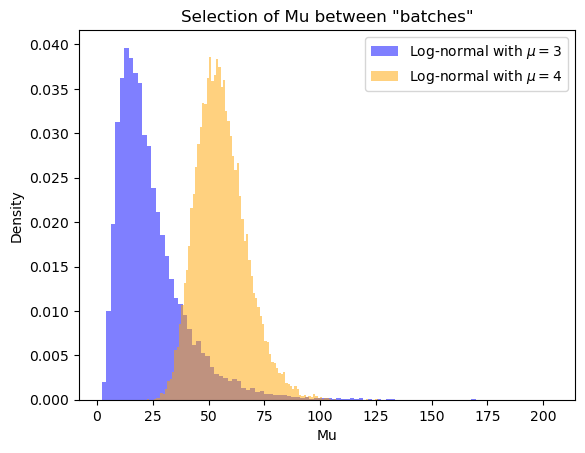

In [14]:
# In this version of the code, I want to create a distribution to "pull" our NB Mu parameters from
# we discussed log-normal
mu_pull_dist_1 = 3
mu_pull_dist_2 = 4


sigma1 = 0.6  # standard deviation of the logarithm of the variable (example value)
sigma2 = 0.2  # standard deviation of the logarithm of the variable (example value)

# Generate a sample from the log-normal distribution
# Generate samples for both distributions
sample_size = patients_to_generate*100 # multiplication ensures a varied number of possible values
samples1 = np.random.lognormal(mean=mu_pull_dist_1, sigma=sigma1, size=sample_size)
samples2 = np.random.lognormal(mean=mu_pull_dist_2, sigma=sigma2, size=sample_size)

samples1_rounded = np.round(samples1, 6)
samples2_rounded = np.round(samples2, 6)

# Plotting the samples
plt.hist(samples1_rounded, bins=100, density=True, alpha=0.5, color='blue', label=f'Log-normal with $\mu={mu_pull_dist_1}$')
plt.hist(samples2_rounded, bins=100, density=True, alpha=0.5, color='orange', label=f'Log-normal with $\mu={mu_pull_dist_2}$')
plt.title('Selection of Mu between "batches"')
plt.xlabel('Mu')
plt.ylabel('Density')
# plt.xscale('log')
plt.legend()
plt.show()

In [15]:
# for now, theta will be simple, both batch 1 and batch 2 will have the same parameters
# will likely make this more complex in the future
theta_pull_dist_1 = theta_pull_dist_2 = theta_value # will try 1, 2, etc


In [16]:
# Container for simulated data
train_data, valid_data, gene_names = [], [], []
gene_mu1, gene_var1, gene_mu2, gene_var2 = [], [], [], []

# we have to sample from both log normals outside of the loop so that we can ensure replacement
sampled_mus_batch1 = np.random.choice(samples1_rounded, size=genes_to_generate, replace=False)
sampled_mus_batch2 = np.random.choice(samples2_rounded, size=genes_to_generate, replace=False)


# Bernouli trial idea didn't work out
# This way, all samples will get the same mu, not a partial amount
samples_indices = np.random.binomial(n=1, p=batch_balance, size=patients_to_generate)

# In 4.2, I'd also like to randomly choose which genes to sort (these ensure that edges will be created)
genes_to_sort = np.random.binomial(n=1, p=gene_sort_prob, size=genes_to_generate)


for i in range(genes_to_generate):
    # so we compute the p and n parameters for each batch using their respective Mu/thetas
    mu_batch1 = sampled_mus_batch1[i]
    var_batch1 = mu_batch1 + (mu_batch1**2 / theta_pull_dist_1)
    n_batch1 = mu_batch1**2 / (var_batch1 - mu_batch1)
    p_batch1 = n_batch1 / (n_batch1 + mu_batch1)

    mu_batch2 = sampled_mus_batch2[i]
    var_batch2 = mu_batch2 + (mu_batch2**2 / theta_pull_dist_2)
    n_batch2 = mu_batch2**2 / (var_batch2 - mu_batch2)
    p_batch2 = n_batch2 / (n_batch2 + mu_batch2)

    # we then sample M (patients) values from both NBs
    counts_batch1 = nbinom.rvs(n_batch1, p_batch1, size=patients_to_generate)
    counts_batch2 = nbinom.rvs(n_batch2, p_batch2, size=patients_to_generate)

    # sorting genes will ensure genes/samples will correlate with each other
    if(genes_to_sort[i] == 1):
        counts_batch1 = np.sort(counts_batch1)
        counts_batch2 = np.sort(counts_batch2)

    # and we use the Bernouli to select from which NB distribution do we take values from
    selected_data_train = np.where(samples_indices == 0, counts_batch1, counts_batch2)
    
    # append it to a list of gene expression values
    train_data.append(selected_data_train)  

    # repeat for validation
    counts_batch3 = nbinom.rvs(n_batch1, p_batch1, size=patients_to_generate)
    counts_batch4 = nbinom.rvs(n_batch2, p_batch2, size=patients_to_generate)

    if(genes_to_sort[i] == 1):
        counts_batch3 = np.sort(counts_batch3)
        counts_batch4 = np.sort(counts_batch4)

    # and we use the Bernouli to select from which NB distribution do we take values from
    selected_data_val = np.where(samples_indices == 0, counts_batch3, counts_batch4)

    # append it to a list of gene expression values
    valid_data.append(selected_data_val)  

    # Saving Mus/Thetas; to be placed in the AnnData 'var' table
    gene_mu1.append(mu_batch1)
    gene_var1.append(theta_pull_dist_1)
    gene_mu2.append(mu_batch2)
    gene_var2.append(theta_pull_dist_2)

    # Creating a unique gene name
    gene_name = "Gene_" + str(i + 1)
    gene_names.append(gene_name)

    # draw expression selected out if desired
    title = "Expression for Gene " + str(i + 1)

    if (draw_NB_data is True):
        plt.hist(selected_data_train, bins=50, color="blue")
        plt.xlabel("Expression")
        plt.ylabel("Frequency")
        plt.title(title)
        plt.show()

        


In [ ]:
# So now we have to save these results as an AnnData table with batch in the obs

# append genes into a single matrix, and transpose so rows are samples and not rows
all_counts = np.array(train_data)
counts_in_anndata_orientation_train = np.transpose(all_counts)

counts_in_anndata_orientation_valid = np.transpose(np.array(valid_data))

# sort samples
split_sort = sample_sort_prob / 2

samples_to_sort = np.random.binomial(n=1, p=split_sort, size=patients_to_generate)
samples_to_reverse_sort = np.random.binomial(n=1, p=split_sort, size=patients_to_generate)

intersected = np.intersect1d(samples_to_sort, samples_to_reverse_sort)

common_indices = [i for i in range(len(genes_to_sort)) if genes_to_sort[i] == 1 and samples_to_reverse_sort[i] == 1]

# if both Bernouli distributions select the same position, set it to the first sort
for index in common_indices:
    samples_to_reverse_sort[index] = 0

for i in range(len(samples_to_sort)):
    if samples_to_sort[i] == 1:
        counts_in_anndata_orientation_train[i] = np.sort(counts_in_anndata_orientation_train[i])
        counts_in_anndata_orientation_valid[i] = np.sort(counts_in_anndata_orientation_valid[i])

for i in range(len(samples_to_reverse_sort)):
    if samples_to_reverse_sort[i] == 1:
        counts_in_anndata_orientation_train[i] = np.sort(counts_in_anndata_orientation_train[i])
        counts_in_anndata_orientation_valid[i] = np.sort(counts_in_anndata_orientation_valid[i])

In [18]:
# creating a "continuous" variable for testing (influenced by "batch" effect)
random_vector = np.where(samples_indices == 0, 
                         np.random.uniform(0, 10, samples_indices.size),
                         np.random.uniform(10, 20, samples_indices.size))


In [ ]:
# if we want, this forcing edges in gene/gene | sample/sample index by copying over its neighboring entry
# samples = True means we create a sample/sample edge, otherwise gene/gene

adata_train = ad.AnnData(X=counts_in_anndata_orientation_train, var=pd.DataFrame(index=gene_names), dtype=np.int64)

# make batch labels
#batch_labels = ['1'] * size_batch1 + ['2'] * size_batch2  # Adjust according to your data structure
adata_train.obs['batch'] = samples_indices
adata_train.obs['random'] = random_vector

# add gene names to var
adata_train.var['gene'] = gene_names
adata_train.var['mu_batch1'] = gene_mu1
adata_train.var['theta_batch1'] = gene_var1
adata_train.var['mu_batch2'] = gene_mu2
adata_train.var['theta_batch2'] = gene_var2


# I still need to generate the gene_gene and sample_sample adjacency matrix!
# gene/gene
df = pd.DataFrame(adata_train.X, columns=adata_train.var_names)

# we no longer create a gene/gene matrix for the simple data
gene_correlation_matrix = df.corr()
gene_gene_adj = (gene_correlation_matrix.abs() > 0.7).astype(int)
np.fill_diagonal(gene_gene_adj.values, 1) # diagonal has been 1s in our other data

# sample/sample
df_transposed = pd.DataFrame(adata_train.X.T, columns=adata_train.obs_names, index=adata_train.var_names)

correlation_matrix_samples = df_transposed.corr()
sample_sample_adj = (correlation_matrix_samples.abs() > 0.7).astype(int)
np.fill_diagonal(sample_sample_adj.values, 1)

# Count the number of 1s in the adjacency matrix
num_ones_samples = np.sum(sample_sample_adj.values)

# and the adjacency tables need to be 'coo'
sample_sample_adj_coo = csc_matrix(sample_sample_adj)
adata_train.obsm['sample_sample_adj'] = sample_sample_adj_coo

gene_gene_adj_coo = csc_matrix(gene_gene_adj)
adata_train.varm['gene_gene_adj'] = gene_gene_adj_coo


# and lets save the data
folder_path = '/path/to/output/'

file_path = folder_path + 'sim_simple_w_layers.M_' + str(patients_to_generate) + '_N_' + str(genes_to_generate) + '_th_' + str(theta_pull_dist_1) + '_batch_bal_' + str(batch_balance) + '.Msort_' + str(sample_sort_prob) + '_Nsort_' + str(gene_sort_prob) + '.train.tau_1.h5ad'

# Save the AnnData object
adata_train.write(file_path)


/home/UWO/emucaki/miniconda3/envs/ffpe_env_gpu/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [ ]:

adata_valid = ad.AnnData(X=counts_in_anndata_orientation_valid, var=pd.DataFrame(index=gene_names), dtype=np.int64)

# make batch labels
#batch_labels = ['1'] * size_batch1 + ['2'] * size_batch2  # Adjust according to your data structure
adata_valid.obs['batch'] = samples_indices
adata_valid.obs['random'] = random_vector

# add gene names to var
adata_valid.var['gene'] = gene_names
adata_valid.var['mu_batch1'] = gene_mu1
adata_valid.var['theta_batch1'] = gene_var1
adata_valid.var['mu_batch2'] = gene_mu2
adata_valid.var['theta_batch2'] = gene_var2


# I still need to generate the gene_gene and sample_sample adjacency matrix!
df = pd.DataFrame(adata_valid.X, columns=adata_valid.var_names)

# we no longer create a gene/gene matrix for the simple data
gene_correlation_matrix = df.corr()
gene_gene_adj = (gene_correlation_matrix.abs() > 0.7).astype(int)
np.fill_diagonal(gene_gene_adj.values, 1) # diagonal has been 1s in our other data

# sample/sample
df_transposed = pd.DataFrame(adata_valid.X.T, columns=adata_valid.obs_names, index=adata_valid.var_names)

correlation_matrix_samples = df_transposed.corr()
sample_sample_adj = (correlation_matrix_samples.abs() > 0.7).astype(int)
np.fill_diagonal(sample_sample_adj.values, 1)

# Count the number of 1s in the adjacency matrix
num_ones_samples = np.sum(sample_sample_adj.values)

# and the adjacency tables need to be 'coo'
sample_sample_adj_coo = csc_matrix(sample_sample_adj)
adata_valid.obsm['sample_sample_adj'] = sample_sample_adj_coo

gene_gene_adj_coo = csc_matrix(gene_gene_adj)
adata_valid.varm['gene_gene_adj'] = gene_gene_adj_coo

file_path = folder_path + 'sim_simple_w_layers.M_' + str(patients_to_generate) + '_N_' + str(genes_to_generate) + '_th_' + str(theta_pull_dist_1) + '_batch_bal_' + str(batch_balance) + '.Msort_' + str(sample_sort_prob) + '_Nsort_' + str(gene_sort_prob) + '.validation.tau_1.h5ad'

# Save the AnnData object
adata_valid.write(file_path)


In [21]:
# checking to see how many sample-sample "edges" were created in this run
print("# Sample Edges", np.sum(np.sum(sample_sample_adj)))
print("# Gene Edges", np.sum(np.sum(gene_gene_adj)))
print(adata_train.var)

# Sample Edges 512
# Gene Edges 320
              gene  mu_batch1  theta_batch1  mu_batch2  theta_batch2
Gene_1      Gene_1  25.743374           0.1  46.943477           0.1
Gene_2      Gene_2  26.226135           0.1  61.398005           0.1
Gene_3      Gene_3  22.299063           0.1  62.272045           0.1
Gene_4      Gene_4  20.128370           0.1  52.178292           0.1
Gene_5      Gene_5  24.306323           0.1  51.035724           0.1
...            ...        ...           ...        ...           ...
Gene_196  Gene_196  13.230894           0.1  48.232236           0.1
Gene_197  Gene_197   9.534179           0.1  64.409580           0.1
Gene_198  Gene_198  18.265221           0.1  54.096690           0.1
Gene_199  Gene_199  21.678256           0.1  69.958760           0.1
Gene_200  Gene_200  30.045819           0.1  58.047362           0.1

[200 rows x 5 columns]


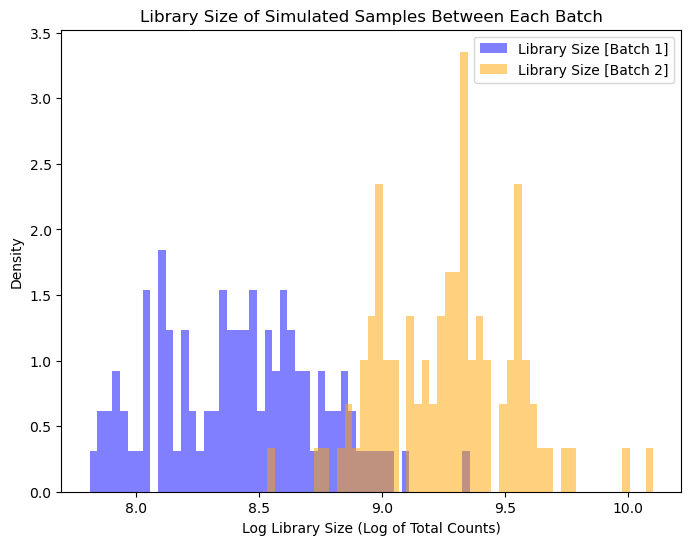

In [22]:
# draw library size information distrubtions
library_sizes = np.log(adata_train.X.sum(axis=1))

batches = adata_train.obs['batch']
library_sizes_batch1 = library_sizes[batches == 0]
library_sizes_batch2 = library_sizes[batches == 1]

# Plotting the samples
#plt.hist(library_sizes, bins=50, density=True, alpha=0.5, color='blue', label=f'Library Size [all samples]')
plt.figure(figsize=(8, 6))
plt.hist(library_sizes_batch1, bins=50, density=True, alpha=0.5, color='blue', label='Library Size [Batch 1]')
plt.hist(library_sizes_batch2, bins=50, density=True, alpha=0.5, color='orange', label='Library Size [Batch 2]')
plt.title('Library Size of Simulated Samples Between Each Batch')
plt.xlabel('Log Library Size (Log of Total Counts)')
plt.ylabel('Density')
# plt.yscale('log')  # Use a log scale for the y-axis
#plt.xscale('log')
plt.legend()
plt.show()

# you can clearly see the difference caused by the two Mus